<a href="https://colab.research.google.com/github/stevengregori92/LearnWord2Vec/blob/main/Sentiment_Analysis_with_FastText.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install luwiji
import nltk
nltk.download('punkt')
nltk.download('stopwords')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.4 MB/s eta 0:00:00
  Created wheel for luwiji: filename=luwiji-1.2.1-py2.py3-none-any.whl size=40366830 sha256=f273542e9155273759334f6ada8220d1803f5c6f76ffbd5e52ba31152abc8cec
  Stored in directory: /root/.cache/pip/wheels/ba/90/9e/943ac5067e9cdc185d8f029a1d13278acd52839118acc06c9a
  Created wheel for jcopml: filename=jcopml-1.2.2-py2.py3-none-any.whl size=32178 sha256=177db9bfc0d3445111ffa081231f9b1ff64a18fc898e3cd61253d7c0d55d1900
  Stored in directory: /root/.cache/pip/wheels/5e/06/58/749e5f1baf2932285758798a92793d4347888826160b025808
Successfully built luwiji jcopml


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

sw_indo = stopwords.words('indonesian') + list(punctuation)

#Import Data

In [ ]:
!gdown https://drive.google.com/uc?id=10OnDq1OAByUxcQEPCDZ19jxU0W8QV6hu
!unzip /content/word2vec.zip

Downloading...
From: https://drive.google.com/uc?id=10OnDq1OAByUxcQEPCDZ19jxU0W8QV6hu
To: /content/word2vec.zip
100% 184k/184k [00:00<00:00, 3.32MB/s]
Archive:  /content/word2vec.zip
   creating: data/
  inflating: data/kompas.txt         
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._kompas.txt  
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
  inflating: data/gojek_review_sentiment.csv  
  inflating: __MACOSX/data/._gojek_review_sentiment.csv  
  inflating: data/gojek_review.csv   


In [ ]:
df = pd.read_csv('data/gojek_review_sentiment.csv')
df

,review,rate
0,Apa aplikasi yang bagus untuk dengan mudah per...,positive
1,Aplikasi ini banyak membantu saya. Sekarang sa...,positive
2,Mengerikan. Antarmukanya sangat membingungkan....,negative
3,Aplikasi yang cukup mengesankan. Butuh waktu l...,positive
4,Aplikasi ini sebenarnya bagus dan sangat memba...,positive
...,...,...
1777,Jelas lebih baik daripada yang lain di luar sa...,positive
1778,"Untuk ruang penyimpanan yang luas, buatlah sed...",negative
1779,"Aplikasi yang sangat bagus, beri kami lebih ba...",positive
1780,cintai ini terutama ketika Anda membutuhkan tr...,positive


In [ ]:
df.rate.value_counts(normalize=True)

negative    0.595398
positive    0.404602
Name: rate, dtype: float64

#Encoding

In [ ]:
from gensim.models import FastText

In [ ]:
!gdown https://drive.google.com/uc?id=1NPFSzJk_zqsE9vOpW1W0hIbWakMU-uW7
!unzip /content/model.zip

Downloading...
From: https://drive.google.com/uc?id=1NPFSzJk_zqsE9vOpW1W0hIbWakMU-uW7
To: /content/model.zip
100% 927M/927M [00:20<00:00, 44.8MB/s]
Archive:  /content/model.zip
  inflating: model/gojek_review.fasttext  
  inflating: model/gojek_review.fasttext.wv.vectors_ngrams.npy  


In [ ]:
w2v = FastText.load('model/gojek_review.fasttext').wv

In [ ]:
def sent_vector(sentence, w2v_model, stopwords):
  vecs = [w2v_model[word.lower()] for word in word_tokenize(sentence) if word not in stopwords]
  sent_vecs = np.mean(vecs, axis=0)
  return sent_vecs

def norm_sent_vector(sentence, w2v_model, stopwords):
  vecs = [w2v_model[word.lower()] for word in word_tokenize(sentence) if word not in stopwords]
  norm_vecs = [vec /np.linalg.norm(vecs) for vec in vecs if np.linalg.norm(vecs) > 0]
  sent_vecs = np.mean(norm_vecs, axis=0)
  return sent_vecs

vecs = [norm_sent_vector(sentence, w2v, sw_indo) for sentence in df.review]
vecs = np.array(vecs)
vecs

array([[ 0.00800301, -0.00107648, -0.00652601, ..., -0.01213939,
        -0.00254229,  0.00467348],
       [ 0.00613725,  0.00394383, -0.00918088, ..., -0.00760593,
        -0.00016488,  0.00931408],
       [-0.01140107,  0.00534018, -0.00365836, ..., -0.0124171 ,
         0.0065056 , -0.00280528],
       ...,
       [ 0.00841327,  0.0238256 , -0.00596167, ..., -0.01010402,
         0.03031906,  0.00260594],
       [ 0.00816073,  0.00147255, -0.00624285, ..., -0.01779971,
         0.02381958, -0.00570163],
       [-0.00089702,  0.00254284, -0.00622446, ..., -0.00971849,
         0.01248588,  0.00772586]], dtype=float32)

#Dataset Splitting

In [ ]:
X = vecs
y = df.rate

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1425, 128), (357, 128), (1425,), (357,))

#Training

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [ ]:
pipeline = Pipeline([
    ('algo', SVC(max_iter=500))
])

model = RandomizedSearchCV(pipeline, rsp.svm_params, cv=4, n_iter=50, verbose=1, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 4 folds for each of 50 candidates, totalling 200 fits
{'algo__C': 4.042872735027338, 'algo__gamma': 17.71884735480683}
0.9347368421052632 0.8722873981053096 0.876750700280112


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


#Evaluation

In [ ]:
from jcopml.plot import plot_confusion_matrix

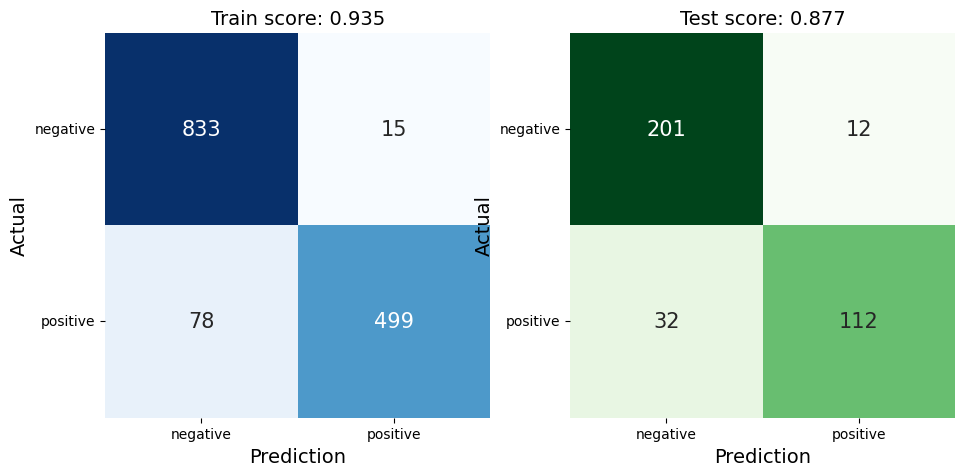

In [ ]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)